<center> <h1><b>Minicurso - Coleta de Dados na Web</b></h1></center>

<h2><b>Coleta de Dados via API</b></h2>

<h3>Bernardo Abreu - Vinícius Silva</h3>

<br/>

## 1- API - Definição
Uma API (**A**pplication **P**rogramming **I**nterface) "é um conjunto de rotinas e padrões estabelecidos por um software para a utilização das suas funcionalidades por aplicativos que não pretendem envolver-se em detalhes da implementação do software, mas apenas usar seus serviços." - *Wikipedia*

Muitos sites disponibilizam API's para que nós programadores possamos consumir seus dados ou serviços de maneira simples e eficiente. Websites amplamente conhecidos que proveem APIs para uso externo incluem o Google Maps, o Twitter, o Spotify e o **Github**.

<br/>

## 2- Github - Definição

GitHub é uma plataforma de hospedagem de código-fonte com controle de versão usando o Git. Ele permite que programadores, utilitários ou qualquer usuário cadastrado na plataforma contribuam em projetos privados e/ou Open Source de qualquer lugar do mundo.

O projeto Tensorflow, idealizado pelo Google, tem seu código hospedado no Github e lá recebe contribuições de vários programadores interessados em Machine Learning. Como todo software em desenvolvimento, comportamento inesperado, documentações inconsistentes, erros de compilação e outros tipos de problema podem aparecer. O Github oferece um mecanismo para que os contribuidores do projeto possam reportar tais problemas e realizar esforços com o intuito de corrigi-los. No Github, um problema dessa natureza é chamado de **Issue**. 

<br/>

## 3- Objetivo
O objetivo deste notebook é guiar o leitor na execução de um código que utiliza a API pública do Github para baixar dados a respeito das issues já resolvidas do projeto Tensorflow (www.tensorflow.org).
Ao final, desenvolvemos uma análise simples dos dados coletados e mostramos alguns insights que podem ser obtidos a partir desses dados. 

<br/>

## 4- Praticando

A primeira coisa a se fazer quando queremos utilizar uma API de terceiros, é ler a documentação (ou ao menos, as partes principais). No caso da API do Github, a documentação está disponível em: https://developer.github.com/v3/ <br/>
Lá, os autores da API explicam como você deve chamar os métodos que a API fornece, quais informações eles retornam, se exigem ou não autenticação, etc. Na documentação, vemos que a API limita o número de requests não autenticadas a 30 por hora por IP. Para que seja possível seguir a aula, criamos uma conta fake no Github e nos registramos como usuários da API. Dessa forma, nosso limite sobe para 5000 requests/hora. Contamos com a colaboração de vocês para que esse número seja suficiente para que todos possam executar.
Dito isso, vamos colocar a mão na massa!

In [0]:
# Importa as bibliotecas que vamos utilizar

# Biblioteca para fazermos requests HTTP através do Python
import requests

# Biblioteca que nos permite ler objetos JSON de uma String
import json

# Biblioteca que nos permite manipular um dataset como uma tabela
import pandas as pd

# Biblioteca que nos permite plotar gráficos facilmente
import seaborn as sns

# Biblioteca que nos permite personalizar os gráficos que plotamos
import matplotlib.pyplot as plt

In [0]:
"""
    Função que recebe uma issue completa do Github e 
    extrai apenas as informações que queremos
    
"""
def format_fields(issue):
    current_issue = {}

    try:
        # Lê o login do user designado para resolver aquela issue
        current_issue['assignee_login'] = issue['assignee']['login']
    except Exception:
        # Se não houver user designado, atribuímos None
        current_issue['assignee_login'] = None

    # Lê data abertura, data fechamento, url, numero de comentários e título 
    current_issue['closed_at'] = issue['closed_at']
    current_issue['created_at'] = issue['created_at']
    current_issue['url'] = issue['html_url']
    current_issue['num_comments'] = issue['comments']
    current_issue['title'] = issue['title']

    # Lê o o login do user que reportou a issue
    try:
        current_issue['author_login'] = issue['user']['login']
    except:
        current_issue['author_login'] = None


    # Itera sobre as labels da issue para que possamos capturar todas
    current_issue['labels'] = []
    for label in issue['labels']:
        current_issue['labels'].append(label['name'])

    return current_issue

In [0]:
# Faz sucessivas requisições a API e recupera 1000 issues do tensorflow
def collect_issues():
    all_issues = []

    # Fazemos um contador para sabermos quantas issues eram na verdade PRs
    not_included = 0
    page = 1

    # Percorreremos a lista de issues
    while True:

        py_res = requests.get(
            ('https://api.github.com/repos/tensorflow/tensorflow/'
            # Perceba que a paginação está acontecendo aqui
            f'issues?state=closed&page={page}&per_page=100'),
            # Autenticamos com o nosso username do Github e nossa API Key
            auth=('evcomp_bigdata', '6479277b0e77c32219c61da17fd038d8532db1be'))
        
        # Carregamos a response da API como um objeto JSON
        issues_tf = json.loads(py_res.text)

        print(f'Downloading issues from page {page}...')

        if len(issues_tf) == 0:
            # Saímos do loop se o numero de issues recuperadas for 0
            break

        for issue in issues_tf:
            # Checa se a issue é na verdade um PR
            if 'pull_request' not in issue.keys():
                cur_issue = format_fields(issue)
                all_issues.append(cur_issue)
            else:
                not_included += 1
        
        page += 1

        # Saímos do loop se passarmos de 10 páginas de issues coletadas
        # NÃO AUMENTE ESSE NÚMERO. PODEMOS TODOS SER BLOQUEADOS PELA API
        if page > 10:
            break

    # Retorna as issues que coletamos
    # O numero de issues sera menor que mil, pois filtramos as que eram PRs
    # Perceba que len(all_issues) + not_included = 1000
    return all_issues

In [0]:
# Função que recebe uma lista de dicts e transforma em um DataFrame
def dicts_to_df(all_issues_dicts):

    # Carregamos nossa lista de JSONs (dicts) como um Pandas Dataframe
    df_issues = pd.DataFrame(all_issues_dicts)
    display(df_issues.head())

    # Convertemos os campos de data de string para datetime
    df_issues['created_at'] = pd.to_datetime(df_issues['created_at'])
    df_issues['closed_at'] = pd.to_datetime(df_issues['closed_at'])

    # Calculamos quantos dias se passaram entre o report e o fechamento da issue
    df_issues['days'] = (
        df_issues['closed_at'] - df_issues['created_at']
    ).apply(lambda x: x.days)

    return df_issues


# Função que pega o DataFrame e plota um histograma e um scatter plot
def draw_plots(df_issues):

    # Plota o histograma 
    # (Fique a vontade para mudar os parametros)
    plt.figure(figsize=(10, 6))
    sns.distplot(df_issues['days'],
                hist=True, kde=False, bins=15,
                hist_kws={'edgecolor':'black'})

    plt.xlabel('Days')
    plt.ylabel('# of issues')
    plt.title('How long does a TensorFlow issue take to be closed?')
    plt.show()


    # Plota o scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(df_issues['num_comments'], df_issues['days'])

    plt.title('# of comments x Days')
    plt.xlabel('# of comments')
    plt.ylabel('Days')
    plt.show()

,assignee_login,closed_at,created_at,url,num_comments,title,author_login,labels
0,ravikyram,2020-02-18T20:03:18Z,2020-02-18T19:31:11Z,https://github.com/tensorflow/tensorflow/issue...,1,TensorFlow Lite Op Request,spate141,[comp:lite]
1,ravikyram,2020-02-17T20:25:35Z,2020-02-17T15:14:44Z,https://github.com/tensorflow/tensorflow/issue...,1,tf.lite.TFLiteConverter error when I trying to...,Ru-Van,[]
2,gadagashwini,2020-02-18T08:01:43Z,2020-02-17T13:54:17Z,https://github.com/tensorflow/tensorflow/issue...,3,decode_wav_op.cc:55 : Invalid argument: Bad fi...,skeydan,"[TF 2.1, comp:ops, type:bug]"
3,amahendrakar,2020-02-17T11:10:12Z,2020-02-17T11:09:19Z,https://github.com/tensorflow/tensorflow/issue...,0,How the Frozen model from tensor flow audio re...,vihari1729,[type:docs]
4,amahendrakar,2020-02-17T05:05:41Z,2020-02-17T03:38:00Z,https://github.com/tensorflow/tensorflow/issue...,1,how to use pretrain weight,aluds123,[type:others]


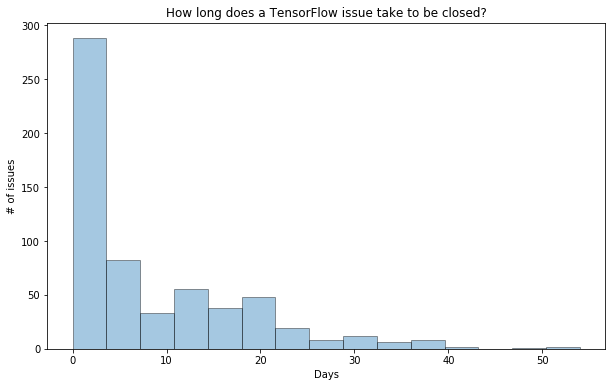

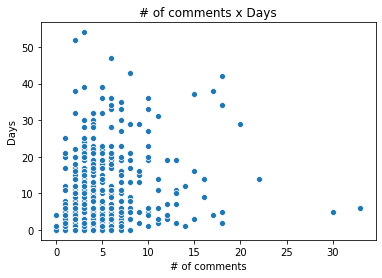

In [0]:
tf_issues = collect_issues()
print('\n')
df_issues = dicts_to_df(tf_issues)
print('\n')
draw_plots(df_issues)